# Notebook to develop HMM model to investigate optimal angle selection

## Defining the targets we will be using in our multiaspect classification model

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.gridspec as gridspec
import matplotlib.cm as cm
import matplotlib.colors as colors

from scipy.special import spherical_jn, spherical_yn

import ipywidgets as widgets
from IPython.display import display

## Below is the analytical DWBA solution for a prolate spheroid geometry

In [2]:
def dwba_prolate_spheroid(L, a, g, h, ka, phi):
    """
    DWBA solution for a fluid prolate spheroid.
    Lee, W.-J., Lavery, A. C., and Stanton, T. K. (2012). 
    “Orientation dependence of broadband acoustic backscattering from live squid,” 
    The Journal of the Acoustical Society of America, 131, 4461–4475. doi:10.1121/1.3701876
    
    Parameters
    ----------
    L : float
        Length of spheroid (long axis) [m]
    a : float
        Radius of spheroid (short axis) [m]
    g : float
        Density contrast (rho2/rho1)
    h : float
        Sound speed contrast (c2/c1)
    ka : array_like
        Dimensionless ka (wavenumber * radius)
    phi : float or array_like
        Incident angle [radians]

    Returns
    -------
    fbs : array_like
        Complex backscattering amplitude
    """
    # Convert inputs to arrays and ensure proper broadcasting
    ka = np.atleast_1d(ka)
    phi = np.atleast_1d(phi)

    # Calculate contrast term
    contrast = 1/(g * h**2) + 1/g - 2
    
    # Convert incident angle to beta
    beta = phi[..., np.newaxis] + np.pi / 2  # Add dimension for broadcasting with ka
    # beta = phi + np.pi/2
    
    # Calculate aspect ratio term (L/2a)
    aspect_ratio = L / (2 * a)

    # Calculate argument for Bessel function
    ellip_term = np.sqrt(np.sin(beta)**2 + (aspect_ratio**2) * np.cos(beta)**2)
    bessel_arg = 2 * ka / h * ellip_term
    
    # Calculate spherical Bessel function
    j1 = spherical_jn(1, bessel_arg)
    
    # Calculate final backscattering amplitude
    fbs = (ka**2) * L * contrast/2 * j1/bessel_arg

    return fbs.squeeze()

## Defining the measurement and target constants

In [3]:
a = 0.15 # semi-minor axis (equatorial radius)
g = 1.043 # density contrast
h = 1.053 # sound speed contrast
c = 1500 # speed of sound in water

freq_lowerbound = 100 # frequency response lower bound
freq_upperbound = 30e3 # frequency response upper bound
freq = np.arange(freq_lowerbound, freq_upperbound, 10)
k = 2*np.pi*freq / c # acoustic wavenumber (phase shift per meter)
ka = k*a

measurement_angle_step = 0.5
angle_all = np.arange(0, 360, measurement_angle_step)

## Below is code borrowed from the [BOAT fundamentals repository](https://boat-fundamentals.readthedocs.io/en/latest/acoustics/TS_03_discrete.html#orientation-dependency)

It has been modified to include an aspect ratio parameter so we can see the 2 targets we need using the slider: a sphere (AR = 1) and spheroid (AR > 1)

In [4]:
def plot_dwba_for_prolate_spheroid(angle, aspect_ratio):
    L = aspect_ratio*2*a

    # TS across all angles
    phi_all = np.deg2rad(angle_all)
    fbs_full = dwba_prolate_spheroid(L, a, g, h, ka, phi_all)
    TS_all = 20*np.log10(np.abs(fbs_full))

    phi = np.deg2rad(angle)
    fbs = dwba_prolate_spheroid(L, a, g, h, ka, phi)
    TS = 20*np.log10(np.abs(fbs))

    # Define ellipse parameters
    width = 2*a  # width
    height = L  # height
    ellipse_angle = 90-angle  # rotation angle [deg]

    # Create the ellipse patch
    ellipse = patches.Ellipse(
        (0.5, 0.5), width, height, angle=ellipse_angle, 
        facecolor='lightblue', edgecolor='blue')

    fig = plt.figure(figsize=(7,6))
    gs = gridspec.GridSpec(2, 2, width_ratios=[2, 1])
    fig.subplots_adjust(hspace=0.1)

    # All angles
    ax0 = fig.add_subplot(gs[0,0])
    ax0.imshow(TS_all, aspect="auto", vmax=-25, vmin=-80,
                extent=(0, freq_upperbound//1e3, 0, 360))
    ax0.set_yticks(np.arange(0, 361, 60))
    ax0.set_ylabel("Incident angle (°)", fontsize=12)
    ax0.set_xlim(freq_lowerbound, freq_upperbound)
    ax0.axhline(angle, color="magenta")

    # One angle slice
    ax1 = fig.add_subplot(gs[1,0], sharex=ax0)
    ax1.plot(freq/1e3, TS, lw=0.75)
    ax1.set_xlim(freq_lowerbound/1e3, freq_upperbound/1e3)
    ax1.set_ylim(-90, -20)
    ax1.set_xlabel("Frequency (kHz)", fontsize=12)
    ax1.set_ylabel("TS (dB)", fontsize=12)

    # Ellipse (cross section of prolate spheroid)
    ax_ellip = fig.add_subplot(gs[1,1])
    ax_ellip.add_patch(ellipse)
    ax_ellip.annotate("Incident sound", xytext=(0.5, 1.2), xy=(0.5, 0.95),
        arrowprops=dict(arrowstyle="->,head_length=0.5,head_width=0.3",
                        linewidth=2),
        fontsize=12,
        ha="center")
    ax_ellip.set_aspect('equal', adjustable='box')
    ax_ellip.axis('off')
    ax_ellip.set_xlim(0, 1)
    ax_ellip.set_ylim(0, 1.2)

    ax0.set_title("TS of a fluid prolate spheroid")
    plt.tight_layout()
    plt.show()

    return TS_all

## Below I have attached two visualizations but both are using the same function

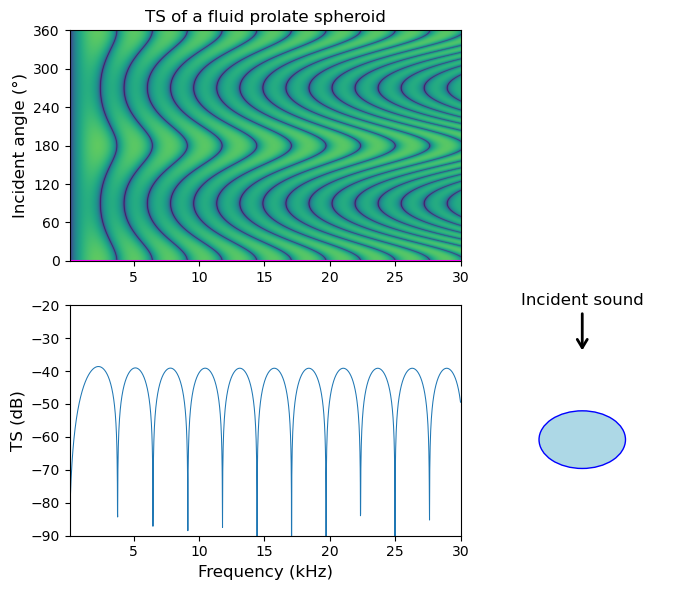

In [5]:
target1_AR = 1.5
TS_all_target1 = plot_dwba_for_prolate_spheroid(angle=0, aspect_ratio=target1_AR)

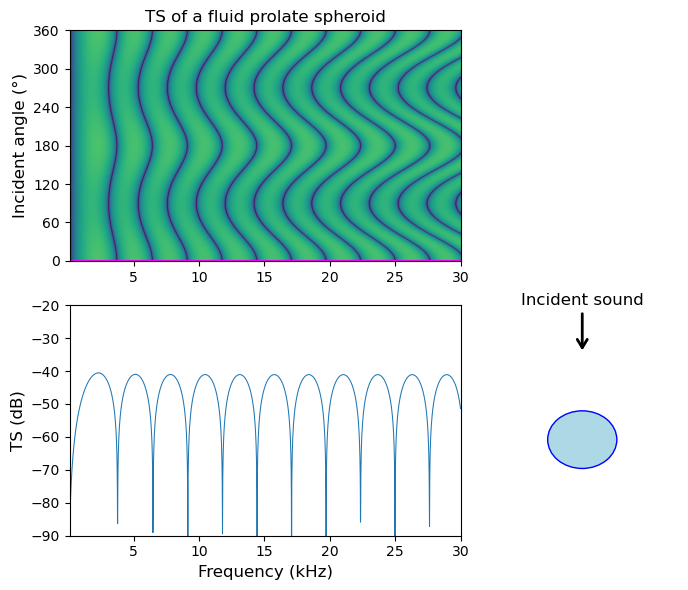

In [6]:
target2_AR = 1.2
TS_all_target2 = plot_dwba_for_prolate_spheroid(angle=0, aspect_ratio=target2_AR)

## Extract the acoustic color from the above functions and plot them side-by-side below

In [7]:
target_ARs = np.arange(1.5, 1.0, -0.3)
target_ARs

array([1.5, 1.2])

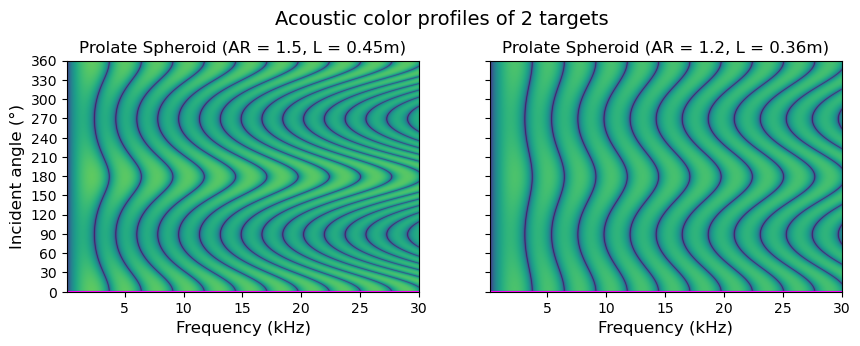

In [8]:
fig, ax = plt.subplots(1, target_ARs.shape[0], figsize=(5*target_ARs.shape[0],3), sharey=True)
plt.rcParams.update({'font.size':10})
fig.subplots_adjust(hspace=0.1)
fig.suptitle(f'Acoustic color profiles of {target_ARs.shape[0]} targets', y=1.05, fontsize=plt.rcParams['font.size']+4)

TS_all_targets = np.zeros((target_ARs.shape[0], angle_all.shape[0], freq.shape[0]))
for i, target_AR in enumerate(target_ARs):
    L = target_AR * 2*a
    phi_all = np.deg2rad(angle_all)
    fbs_full = dwba_prolate_spheroid(L, a, g, h, ka, phi_all)
    TS_all_targets[i,:,:] = 20*np.log10(np.abs(fbs_full))

    ax_TS = ax[i]
    ax_TS.set_title(f'Prolate Spheroid (AR = {target_AR:.1f}, L = {target_AR*2*a:.2f}m)')
    ax_TS.imshow(TS_all_targets[i,:] , aspect="auto", vmax=-25, vmin=-80,
                extent=(0, freq_upperbound//1e3, 0, 360))
    ax_TS.set_yticks(np.arange(0, 361, 30))
    if i==0:
        ax_TS.set_ylabel("Incident angle (°)", fontsize=12)
    ax_TS.axhline(0, color="magenta")
    ax_TS.set_xlim(freq_lowerbound/1e3, freq_upperbound/1e3)
    ax_TS.set_xlabel("Frequency (kHz)", fontsize=12)

plt.show()

In [9]:
all_waveforms_collection = np.vstack(TS_all_targets)
all_waveforms_collection

array([[-85.64708092, -83.99397243, -82.48527668, ..., -48.83383597,
        -49.13767041, -49.45380027],
       [-85.6470821 , -83.99397386, -82.48527838, ..., -48.87728219,
        -49.18283231, -49.5008053 ],
       [-85.64708564, -83.99397813, -82.48528347, ..., -49.0090163 ,
        -49.31981751, -49.64343629],
       ...,
       [-87.58528492, -85.93217721, -84.42348232, ..., -50.9104497 ,
        -51.21977789, -51.54181221],
       [-87.58528284, -85.9321747 , -84.42347933, ..., -50.8332707 ,
        -51.13952558, -51.45825588],
       [-87.5852816 , -85.93217319, -84.42347754, ..., -50.78730283,
        -51.09173925, -51.4085157 ]], shape=(1440, 2990))

In [10]:
from sklearn.cluster import KMeans
import seaborn as sns
import pandas as pd

/Users/adityakrishna/.local/share/mamba/envs/muri-info/lib/python3.13/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


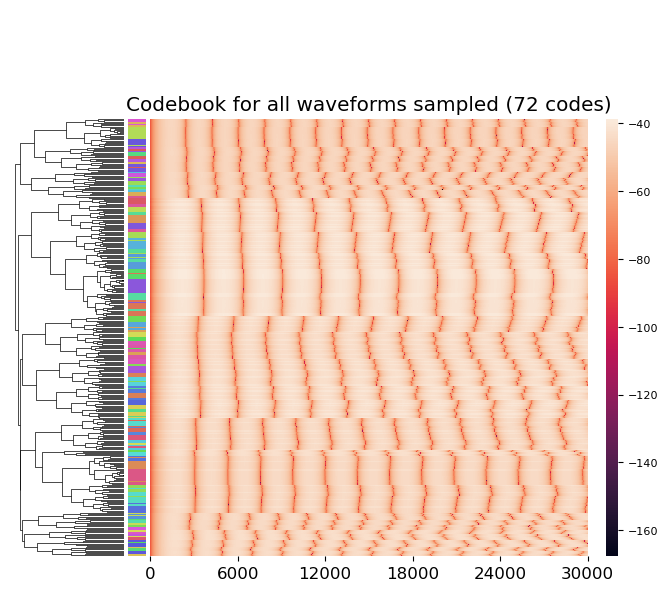

In [11]:
# Perform k-means clustering
k = all_waveforms_collection.shape[0]//20
state = 1500
kmean_TS_codebook = KMeans(n_clusters=k, n_init=10, random_state=state).fit(all_waveforms_collection)

# Create row colors for clustermap
labels = kmean_TS_codebook.labels_

# Get k distinct colors from a Seaborn palette
palette = sns.color_palette("hls", k)
# Map each cluster label to a color
row_colors = [palette[label] for label in labels]

plt.rcParams.update({'font.size':12})
# Create the clustermap
grid_cluster = sns.clustermap(
    all_waveforms_collection,
    col_cluster=False,
    row_colors=row_colors,
    cbar_pos=(1.0, 0.145, 0.02, 0.663),
    yticklabels=False,
    tree_kws=dict(linewidths=0.5, colors='k')
)

# Extract the figure and axes from sns.clustermap
fig = grid_cluster.figure
heatmap_ax = grid_cluster.ax_heatmap
dendro_ax = grid_cluster.ax_row_dendrogram

heatmap_ax.set_title(f'Codebook for all waveforms sampled ({k} codes)')
fig.set_figheight(6)
fig.set_figwidth(6)
# Adjust heatmap and dendrogram positions to align perfectly
heatmap_bbox = heatmap_ax.get_position(original=False)
dendro_bbox = dendro_ax.get_position(original=False)

# Reduce white space by directly setting the positions
heatmap_ax.set_position([heatmap_bbox.x0, heatmap_bbox.y0, heatmap_bbox.width, heatmap_bbox.height])
dendro_ax.set_position([dendro_bbox.x0, heatmap_bbox.y0, dendro_bbox.width, heatmap_bbox.height])

xticks = np.linspace(0, 3000, 6)
# Customize heatmap x-axis
heatmap_ax.set_xticks(xticks*(2985/3000))
heatmap_ax.set_xticklabels((xticks*10).astype(int), rotation=0)
heatmap_ax.set_ylabel('')
heatmap_ax.set_xlabel('')

# Adjust the colorbar position and labels
cbar = grid_cluster.cax
cbar.set_position([heatmap_bbox.x1 + 0.03, heatmap_bbox.y0, 0.02, heatmap_bbox.height]) 
cbar.tick_params(labelsize=plt.rcParams['font.size']-4)
plt.show()

In [12]:
state_angle_step = 5

In [13]:
kmean_TS_codebook.n_clusters

72

In [14]:
kmean_TS_codebook.labels_

array([25, 25, 25, ..., 52, 52, 52], shape=(1440,), dtype=int32)

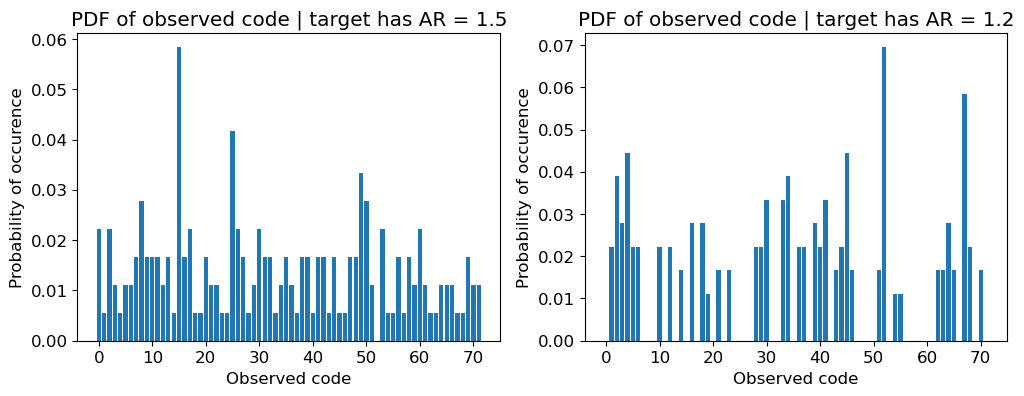

In [15]:
fig, ax = plt.subplots(1, TS_all_targets.shape[0], figsize=(6*TS_all_targets.shape[0], 4))

for i in range(TS_all_targets.shape[0]):
    target_cluster_preds = kmean_TS_codebook.predict(TS_all_targets[i,:])
    density, clusters = np.histogram(target_cluster_preds, bins=np.arange(0, kmean_TS_codebook.n_clusters+1), density=True)

    pdf_ax = ax[i]
    pdf_ax.set_title(f'PDF of observed code | target has AR = {target_ARs[i]:.1f}')
    pdf_ax.bar(x=clusters[:-1], height=density)
    pdf_ax.set_ylabel('Probability of occurence')
    pdf_ax.set_xlabel('Observed code')

plt.show()

In [16]:
state_centers = np.arange(0, 360, state_angle_step) + 2.5
state_centers

array([  2.5,   7.5,  12.5,  17.5,  22.5,  27.5,  32.5,  37.5,  42.5,
        47.5,  52.5,  57.5,  62.5,  67.5,  72.5,  77.5,  82.5,  87.5,
        92.5,  97.5, 102.5, 107.5, 112.5, 117.5, 122.5, 127.5, 132.5,
       137.5, 142.5, 147.5, 152.5, 157.5, 162.5, 167.5, 172.5, 177.5,
       182.5, 187.5, 192.5, 197.5, 202.5, 207.5, 212.5, 217.5, 222.5,
       227.5, 232.5, 237.5, 242.5, 247.5, 252.5, 257.5, 262.5, 267.5,
       272.5, 277.5, 282.5, 287.5, 292.5, 297.5, 302.5, 307.5, 312.5,
       317.5, 322.5, 327.5, 332.5, 337.5, 342.5, 347.5, 352.5, 357.5])

In [17]:
state_centers.shape

(72,)

In [18]:
state_center = state_centers[0]
state_center

np.float64(2.5)

In [19]:
angle_indices_for_state = np.where((state_center-(state_angle_step/2)<=angle_all)&(angle_all<state_center+(state_angle_step/2)))
angle_indices_for_state

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),)

In [20]:
angle_all[angle_indices_for_state]

array([0. , 0.5, 1. , 1.5, 2. , 2.5, 3. , 3.5, 4. , 4.5])

In [21]:
TS_state_target1 = TS_all_targets[0, angle_indices_for_state, :][0]
TS_state_target1

array([[-85.64708092, -83.99397243, -82.48527668, ..., -48.83383597,
        -49.13767041, -49.45380027],
       [-85.6470821 , -83.99397386, -82.48527838, ..., -48.87728219,
        -49.18283231, -49.5008053 ],
       [-85.64708564, -83.99397813, -82.48528347, ..., -49.0090163 ,
        -49.31981751, -49.64343629],
       ...,
       [-85.64713858, -83.9940422 , -82.48535972, ..., -51.28524161,
        -51.69982702, -52.13650189],
       [-85.6471562 , -83.99406352, -82.48538509, ..., -52.20411446,
        -52.66873996, -53.16094575],
       [-85.64717615, -83.99408766, -82.48541383, ..., -53.38044615,
        -53.91743554, -54.49115328]], shape=(10, 2990))

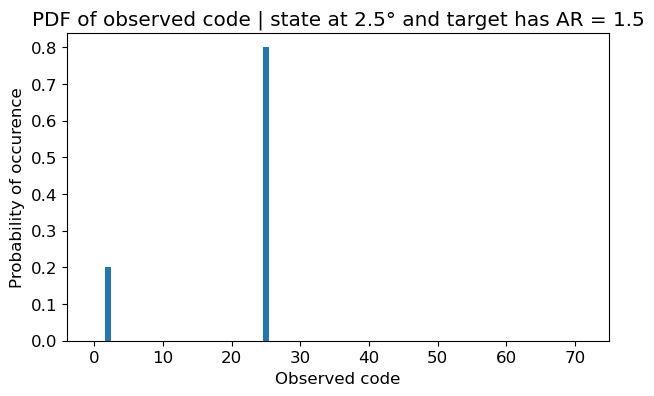

In [22]:
target1_state_cluster_preds = kmean_TS_codebook.predict(TS_state_target1)
density, clusters = np.histogram(target1_state_cluster_preds, bins=np.arange(0, kmean_TS_codebook.n_clusters+1), density=True)

fig, ax = plt.subplots(1, 1, figsize=(7,4))

ax.set_title(f'PDF of observed code | state at {state_center}° and target has AR = {target1_AR}')
ax.bar(x=clusters[:-1], height=density)
ax.set_ylabel('Probability of occurence')
ax.set_xlabel('Observed code')
plt.show()

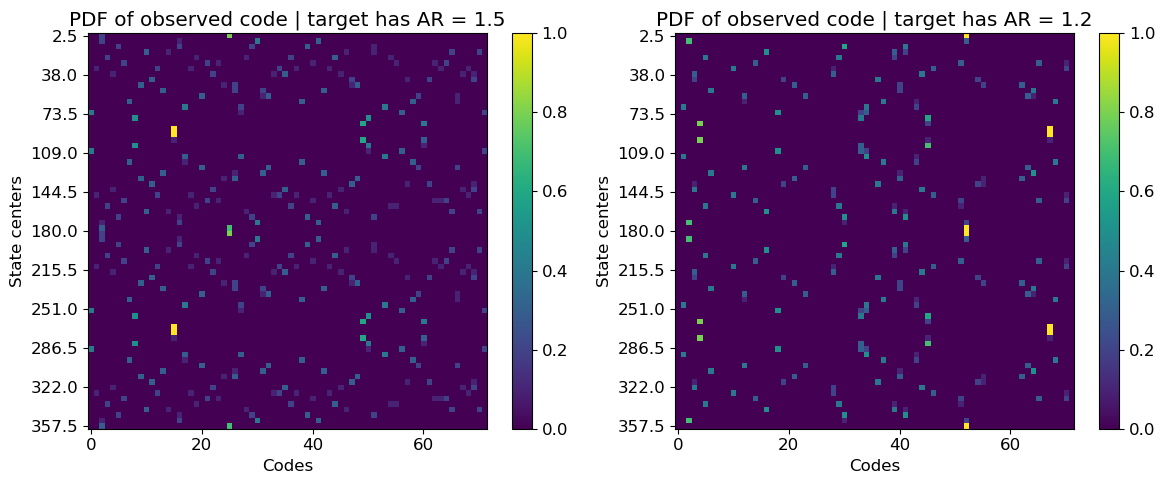

In [23]:
fig, ax_all = plt.subplots(1, TS_all_targets.shape[0], figsize=(6*TS_all_targets.shape[0], 5))

emission_matrix_B_targets = np.zeros((state_centers.shape[0], kmean_TS_codebook.n_clusters, TS_all_targets.shape[0]))
for k in range(TS_all_targets.shape[0]):
    for i, state_center in enumerate(state_centers):
        angle_indices_for_state = np.where((state_center-(state_angle_step/2)<=angle_all)&(angle_all<state_center+(state_angle_step/2)))
        TS_state_target_k = TS_all_targets[k, angle_indices_for_state][0]
        target_k_state_cluster_preds = kmean_TS_codebook.predict(TS_state_target_k)

        density, clusters = np.histogram(target_k_state_cluster_preds, bins=np.arange(0, kmean_TS_codebook.n_clusters+1), density=True)
        emission_matrix_B_targets[i, :, k] = density

    ax = ax_all[k]
    im = ax.imshow(emission_matrix_B_targets[:,:,k], aspect='auto')
    fig.colorbar(im, ax=ax)
    ax.set_title(f'PDF of observed code | target has AR = {target_ARs[k]}')

    ax.set_yticks(np.linspace(0, state_centers.shape[0]-1, 11))
    ax.set_yticklabels(np.linspace(0, 355, 11)+2.5)
    ax.set_ylabel('State centers')
    ax.set_xlabel('Codes')

plt.tight_layout()
plt.show()

In [24]:
state_centers

array([  2.5,   7.5,  12.5,  17.5,  22.5,  27.5,  32.5,  37.5,  42.5,
        47.5,  52.5,  57.5,  62.5,  67.5,  72.5,  77.5,  82.5,  87.5,
        92.5,  97.5, 102.5, 107.5, 112.5, 117.5, 122.5, 127.5, 132.5,
       137.5, 142.5, 147.5, 152.5, 157.5, 162.5, 167.5, 172.5, 177.5,
       182.5, 187.5, 192.5, 197.5, 202.5, 207.5, 212.5, 217.5, 222.5,
       227.5, 232.5, 237.5, 242.5, 247.5, 252.5, 257.5, 262.5, 267.5,
       272.5, 277.5, 282.5, 287.5, 292.5, 297.5, 302.5, 307.5, 312.5,
       317.5, 322.5, 327.5, 332.5, 337.5, 342.5, 347.5, 352.5, 357.5])

In [25]:
(state_centers[np.newaxis, :] - state_centers[:, np.newaxis])

array([[   0.,    5.,   10., ...,  345.,  350.,  355.],
       [  -5.,    0.,    5., ...,  340.,  345.,  350.],
       [ -10.,   -5.,    0., ...,  335.,  340.,  345.],
       ...,
       [-345., -340., -335., ...,    0.,    5.,   10.],
       [-350., -345., -340., ...,   -5.,    0.,    5.],
       [-355., -350., -345., ...,  -10.,   -5.,    0.]], shape=(72, 72))

In [26]:
def w_(theta):
    sigma_i = state_angle_step / 2
    normalization = 1 / np.sqrt(2*np.pi*(sigma_i**2))

    return normalization * np.exp(-0.5*((theta/sigma_i)**2))

def state_transition_model(delta_angle):
    angular_dist_between_states = (state_centers[np.newaxis, :] - state_centers[:, np.newaxis])

    return w_(angular_dist_between_states - delta_angle)

In [27]:
prior_class_prob = 1/2
true_target_L = target_ARs[1]*2*a

initial_state_prob = state_angle_step / 360
initial_state = 45 # np.random.uniform(low=0, high=360)
initial_state

45

In [28]:
alpha_targets = initial_state_prob * emission_matrix_B_targets
alpha_targets

array([[[0.        , 0.        ],
        [0.        , 0.        ],
        [0.00277778, 0.        ],
        ...,
        [0.        , 0.        ],
        [0.        , 0.        ],
        [0.        , 0.        ]],

       [[0.        , 0.        ],
        [0.        , 0.        ],
        [0.00277778, 0.00972222],
        ...,
        [0.        , 0.        ],
        [0.        , 0.        ],
        [0.        , 0.        ]],

       [[0.        , 0.        ],
        [0.        , 0.        ],
        [0.        , 0.        ],
        ...,
        [0.        , 0.        ],
        [0.        , 0.        ],
        [0.        , 0.        ]],

       ...,

       [[0.        , 0.        ],
        [0.        , 0.        ],
        [0.        , 0.        ],
        ...,
        [0.        , 0.        ],
        [0.        , 0.        ],
        [0.        , 0.        ]],

       [[0.        , 0.        ],
        [0.        , 0.        ],
        [0.00138889, 0.00972222],
        .

In [29]:
phi = np.deg2rad(initial_state)
fbs = dwba_prolate_spheroid(true_target_L, a, g, h, ka, phi)

received_TS = 20*np.log10(np.abs(fbs))
received_TS

array([-87.58800386, -85.93546744, -84.42739838, ..., -54.62334383,
       -54.20434679, -53.80607449], shape=(2990,))

In [30]:
received_code = kmean_TS_codebook.predict(received_TS.reshape((1, freq.shape[0])))[0]
received_code

np.int32(55)

In [31]:
emission_matrix_B_targets[:,received_code,:]

array([[0. , 0. ],
       [0. , 0. ],
       [0. , 0. ],
       [0. , 0. ],
       [0. , 0. ],
       [0.1, 0. ],
       [0. , 0. ],
       [0. , 0. ],
       [0. , 0. ],
       [0. , 0.2],
       [0. , 0. ],
       [0. , 0. ],
       [0. , 0. ],
       [0. , 0. ],
       [0. , 0. ],
       [0. , 0. ],
       [0. , 0. ],
       [0. , 0. ],
       [0. , 0. ],
       [0. , 0. ],
       [0. , 0. ],
       [0. , 0. ],
       [0. , 0. ],
       [0. , 0. ],
       [0. , 0. ],
       [0. , 0. ],
       [0. , 0.1],
       [0. , 0.1],
       [0. , 0. ],
       [0. , 0. ],
       [0. , 0. ],
       [0.1, 0. ],
       [0. , 0. ],
       [0. , 0. ],
       [0. , 0. ],
       [0. , 0. ],
       [0. , 0. ],
       [0. , 0. ],
       [0. , 0. ],
       [0. , 0. ],
       [0. , 0. ],
       [0.1, 0. ],
       [0. , 0. ],
       [0. , 0. ],
       [0. , 0. ],
       [0. , 0.2],
       [0. , 0. ],
       [0. , 0. ],
       [0. , 0. ],
       [0. , 0. ],
       [0. , 0. ],
       [0. , 0. ],
       [0. ,

In [32]:
alpha_targets_for_received_code = alpha_targets[:,received_code,:]
alpha_targets_for_received_code

array([[0.        , 0.        ],
       [0.        , 0.        ],
       [0.        , 0.        ],
       [0.        , 0.        ],
       [0.        , 0.        ],
       [0.00138889, 0.        ],
       [0.        , 0.        ],
       [0.        , 0.        ],
       [0.        , 0.        ],
       [0.        , 0.00277778],
       [0.        , 0.        ],
       [0.        , 0.        ],
       [0.        , 0.        ],
       [0.        , 0.        ],
       [0.        , 0.        ],
       [0.        , 0.        ],
       [0.        , 0.        ],
       [0.        , 0.        ],
       [0.        , 0.        ],
       [0.        , 0.        ],
       [0.        , 0.        ],
       [0.        , 0.        ],
       [0.        , 0.        ],
       [0.        , 0.        ],
       [0.        , 0.        ],
       [0.        , 0.        ],
       [0.        , 0.00138889],
       [0.        , 0.00138889],
       [0.        , 0.        ],
       [0.        , 0.        ],
       [0.

In [33]:
alpha_targets_for_received_code.shape

(72, 2)

In [34]:
likelihood_targets_for_received_code = alpha_targets_for_received_code.sum(axis=0)
likelihood_targets_for_received_code

array([0.00555556, 0.01111111])

In [35]:
posterior = (likelihood_targets_for_received_code) / np.sum(likelihood_targets_for_received_code)
posterior

array([0.33333333, 0.66666667])

In [36]:
entropy_of_current_belief = -1 * np.sum(posterior * np.log10(posterior + np.nextafter(0, 1)))
entropy_of_current_belief

np.float64(0.27643459094367495)

In [37]:
candidate_angle_steps = np.arange(-5, 10, 10)
candidate_angle_steps

array([-5,  5])

In [38]:
candidate_next_states = candidate_angle_steps + initial_state
candidate_next_states

array([40, 50])

In [39]:
iterations = 10

iter_num = 0
forecasted_delta_S_vals = np.zeros((iterations, candidate_angle_steps.shape[0]))

i_step = 0
candidate_angle_step = candidate_angle_steps[i_step]
candidate_next_state = candidate_next_states[i_step]
print(f'Forecasting action={candidate_angle_step} to state={candidate_next_state}')

A_step = state_transition_model(candidate_angle_step)
print(f'Building state transition matrix A of shape {A_step.shape}')

likelihood_observing_and_transitioning = np.matmul(alpha_targets_for_received_code.T, A_step).T
alpha_targets_for_forecasted_codes = likelihood_observing_and_transitioning[:, np.newaxis, :] * emission_matrix_B_targets

likelihood_targets_for_forecasted_codes = alpha_targets_for_forecasted_codes.sum(axis=0)
numerator = likelihood_targets_for_forecasted_codes.sum(axis=1)
denominator = likelihood_targets_for_received_code.sum()

forecasted_posteriors_for_codes = (likelihood_targets_for_forecasted_codes / np.sum(likelihood_targets_for_forecasted_codes))
entropy_of_forecasted_belief_for_codes = - (forecasted_posteriors_for_codes * np.log(forecasted_posteriors_for_codes + np.nextafter(0, 1))).sum(axis=1)

expected_entropy_of_forecasted_belief = (entropy_of_forecasted_belief_for_codes * numerator / denominator).sum()
print(f'Expected entropy {expected_entropy_of_forecasted_belief}')

delta_S = entropy_of_current_belief - expected_entropy_of_forecasted_belief
print(f'Expected change in entropy {delta_S}')
forecasted_delta_S_vals[iter_num, i_step] = delta_S

angle_step_to_make = candidate_angle_steps[(forecasted_delta_S_vals[iter_num]).argmax()]
angle_step_to_make

Forecasting action=-5 to state=40
Building state transition matrix A of shape (72, 72)
Expected entropy 0.04933238567731963
Expected change in entropy 0.22710220526635533


np.int64(-5)

In [40]:
i_step = 1
candidate_angle_step = candidate_angle_steps[i_step]
candidate_next_state = candidate_next_states[i_step]
print(f'Forecasting action={candidate_angle_step} to state={candidate_next_state}')

A_step = state_transition_model(candidate_angle_step)
print(f'Building state transition matrix A of shape {A_step.shape}')

likelihood_observing_and_transitioning = np.matmul(alpha_targets_for_received_code.T, A_step).T
alpha_targets_for_forecasted_codes = likelihood_observing_and_transitioning[:, np.newaxis, :] * emission_matrix_B_targets

likelihood_targets_for_forecasted_codes = alpha_targets_for_forecasted_codes.sum(axis=0)
numerator = likelihood_targets_for_forecasted_codes.sum(axis=1)
denominator = likelihood_targets_for_received_code.sum()

forecasted_posteriors_for_codes = (likelihood_targets_for_forecasted_codes / np.sum(likelihood_targets_for_forecasted_codes))
entropy_of_forecasted_belief_for_codes = - (forecasted_posteriors_for_codes * np.log(forecasted_posteriors_for_codes + np.nextafter(0, 1))).sum(axis=1)

expected_entropy_of_forecasted_belief = (entropy_of_forecasted_belief_for_codes * numerator / denominator).sum()
print(f'Expected entropy {expected_entropy_of_forecasted_belief}')

delta_S = entropy_of_current_belief - expected_entropy_of_forecasted_belief
print(f'Expected change in entropy {delta_S}')
forecasted_delta_S_vals[iter_num, i_step] = delta_S

angle_step_to_make = candidate_angle_steps[(forecasted_delta_S_vals[iter_num]).argmax()]
angle_step_to_make

Forecasting action=5 to state=50
Building state transition matrix A of shape (72, 72)
Expected entropy 0.03305954379159439
Expected change in entropy 0.24337504715208055


np.int64(5)

In [41]:
forecasted_delta_S_vals

array([[0.22710221, 0.24337505],
       [0.        , 0.        ],
       [0.        , 0.        ],
       [0.        , 0.        ],
       [0.        , 0.        ],
       [0.        , 0.        ],
       [0.        , 0.        ],
       [0.        , 0.        ],
       [0.        , 0.        ],
       [0.        , 0.        ]])

In [61]:
max_iter = 1000
num_trials = 100
classification_threshold = 1.0
candidate_angle_steps = np.array([-5, 5])
# candidate_angle_steps = np.hstack([np.arange(-30, 0, 5), np.arange(5, 31, 5)])
true_target_L = target_ARs[1]*2*a
state_angle_step = 5
prior_class_prob = np.ones(target_ARs.shape[0]) * 1/2

first_state = 0
last_state = 180
initial_states = np.random.uniform(low=first_state, high=last_state, size=num_trials)
candidate_angle_steps

array([-5,  5])

In [62]:
current_belief_posteriors_per_trial = np.full((num_trials, max_iter, target_ARs.shape[0]), np.nan)
current_belief_entropies_per_trial = np.full((num_trials, max_iter), np.nan)
states_tracked_per_trial = np.zeros((num_trials, max_iter))
time_to_complete_per_trial = np.full(num_trials, np.nan)
angle_step_frequency_per_trial = np.zeros((num_trials, candidate_angle_steps.shape[0]))
forecasted_delta_S_vals_per_trial = np.full((num_trials, max_iter, candidate_angle_steps.shape[0]), np.nan)
forecasted_expected_entropy_per_trial = np.full((num_trials, max_iter, candidate_angle_steps.shape[0]), np.nan)
angle_steps_taken_per_trial = np.full((num_trials, max_iter), np.nan)

for trial_t in range(num_trials):
    iter_num = 0
    alpha_targets_for_received_code = np.zeros((max_iter+1, state_centers.shape[0], target_ARs.shape[0]))

    initial_state = initial_states[trial_t]
    initial_state_prob = state_angle_step / 360

    current_belief_entropies = np.full(max_iter, np.nan)
    current_belief_posteriors = np.full((max_iter, target_ARs.shape[0]), np.nan)

    current_state = initial_state
    states_tracked = np.full(max_iter, np.nan)
    posterior = np.zeros(target_ARs.shape[0])

    while (iter_num < max_iter):
        print(f'Currently in state containing: {current_state} at t={iter_num}')
        states_tracked[iter_num] = current_state

        phi = np.deg2rad(current_state)
        fbs = dwba_prolate_spheroid(true_target_L, a, g, h, ka, phi)

        received_TS = 20*np.log10(np.abs(fbs))
        received_code = kmean_TS_codebook.predict(received_TS.reshape((1, freq.shape[0])))[0]
        print(f'Received observation and mapped to cluster {received_code}')

        A_step = state_transition_model(angle_step_to_make)

        if iter_num==0:
            alpha_targets = initial_state_prob * emission_matrix_B_targets
            alpha_targets_for_received_code[iter_num+1,:,:] = alpha_targets[:,received_code,:]
        else:
            likelihood_observing_and_transitioning = np.matmul(alpha_targets_for_received_code[iter_num,:,:].T, A_step).T
            alpha_targets_for_received_codes = likelihood_observing_and_transitioning[:, np.newaxis, :] * emission_matrix_B_targets
            alpha_targets_for_received_code[iter_num+1,:,:] = alpha_targets_for_received_codes[:,received_code,:]
            
        likelihood_targets_for_received_code = alpha_targets_for_received_code[iter_num+1,:,:].sum(axis=0)
        posterior = (likelihood_targets_for_received_code) / np.sum(likelihood_targets_for_received_code)
        current_belief_posteriors[iter_num, :] = posterior
        print(f'Posterior of current state after making observation={received_code}: {posterior}')
        entropy_of_current_belief = -1 * np.sum(posterior * np.log10(posterior + np.nextafter(0, 1)))
        current_belief_entropies[iter_num] = entropy_of_current_belief
        print(f'Entropy of current state after making observation={received_code}: {entropy_of_current_belief:.2f}')

        if (np.isclose(posterior, classification_threshold, atol=1e-3).any()):
            break
        else:
            for i_step in range(candidate_angle_steps.shape[0]):
                candidate_angle_step = candidate_angle_steps[i_step]
                candidate_next_state = (candidate_angle_step + current_state) % 360
                print(f'Forecasting action={candidate_angle_step} to state={candidate_next_state}')

                A_step_candidates = state_transition_model(candidate_angle_step)
                print(f'Building state transition matrix A of shape {A_step_candidates.shape}')

                likelihood_observing_and_transitioning = np.matmul(alpha_targets_for_received_code[iter_num + 1,:,:].T, A_step_candidates).T
                alpha_targets_for_forecasted_codes = likelihood_observing_and_transitioning[:, np.newaxis, :] * emission_matrix_B_targets

                likelihood_targets_for_forecasted_codes = alpha_targets_for_forecasted_codes.sum(axis=0)
                numerator = likelihood_targets_for_forecasted_codes.sum(axis=1)
                denominator = likelihood_targets_for_received_code.sum()

                forecasted_posteriors_for_codes = (likelihood_targets_for_forecasted_codes / np.sum(likelihood_targets_for_forecasted_codes))
                entropy_of_forecasted_belief_for_codes = - (forecasted_posteriors_for_codes * np.log(forecasted_posteriors_for_codes + np.nextafter(0, 1))).sum(axis=1)

                expected_entropy_of_forecasted_belief = (entropy_of_forecasted_belief_for_codes * numerator / denominator).sum()
                forecasted_expected_entropy_per_trial[trial_t, iter_num, i_step] = expected_entropy_of_forecasted_belief
                print(f'Expected entropy {expected_entropy_of_forecasted_belief}')

                delta_S = entropy_of_current_belief - expected_entropy_of_forecasted_belief
                print(f'Expected change in entropy {delta_S}')
                forecasted_delta_S_vals_per_trial[trial_t, iter_num, i_step] = delta_S

            angle_step_to_make = candidate_angle_steps[(forecasted_delta_S_vals_per_trial[trial_t, iter_num, :]).argmax()]
            if angle_step_to_make<0:
                print(f'Optimal angle step to take: {abs(angle_step_to_make)} degrees clockwise')
            else:
                print(f'Optimal angle step to take: {abs(angle_step_to_make)} degrees counter-clockwise')
            angle_steps_taken_per_trial[trial_t, iter_num] = angle_step_to_make
            
            angle_step_frequency_per_trial[trial_t, (forecasted_delta_S_vals_per_trial[trial_t, iter_num, :]).argmax()] += 1

            current_state = (current_state + angle_step_to_make) % 360
            print(f'Moving to: {current_state}')
            iter_num += 1

    states_tracked = np.array(states_tracked)
    states_tracked_per_trial[trial_t,:] = states_tracked
    current_belief_posteriors_per_trial[trial_t,:,:] = current_belief_posteriors
    current_belief_entropies_per_trial[trial_t,:] = current_belief_entropies
    time_to_complete_per_trial[trial_t] = iter_num

Currently in state containing: 116.52032570412887 at t=0
Received observation and mapped to cluster 68
Posterior of current state after making observation=68: [0.2 0.8]
Entropy of current state after making observation=68: 0.22
Forecasting action=-5 to state=111.52032570412887
Building state transition matrix A of shape (72, 72)
Expected entropy 0.04263401831421991
Expected change in entropy 0.174687992959429
Forecasting action=5 to state=121.52032570412887
Building state transition matrix A of shape (72, 72)
Expected entropy 0.04388499786109482
Expected change in entropy 0.1734370134125541
Optimal angle step to take: 5 degrees clockwise
Moving to: 111.52032570412887
Currently in state containing: 111.52032570412887 at t=1
Received observation and mapped to cluster 34
Posterior of current state after making observation=34: [0.02502803 0.97497197]
Entropy of current state after making observation=34: 0.05
Forecasting action=-5 to state=106.52032570412887
Building state transition matrix

In [63]:
angle_steps_taken_per_trial

array([[-5.,  5., nan, ..., nan, nan, nan],
       [ 5.,  5., -5., ..., nan, nan, nan],
       [ 5., -5.,  5., ..., nan, nan, nan],
       ...,
       [-5., -5.,  5., ..., nan, nan, nan],
       [-5., -5., nan, ..., nan, nan, nan],
       [-5., -5., -5., ..., nan, nan, nan]], shape=(100, 1000))

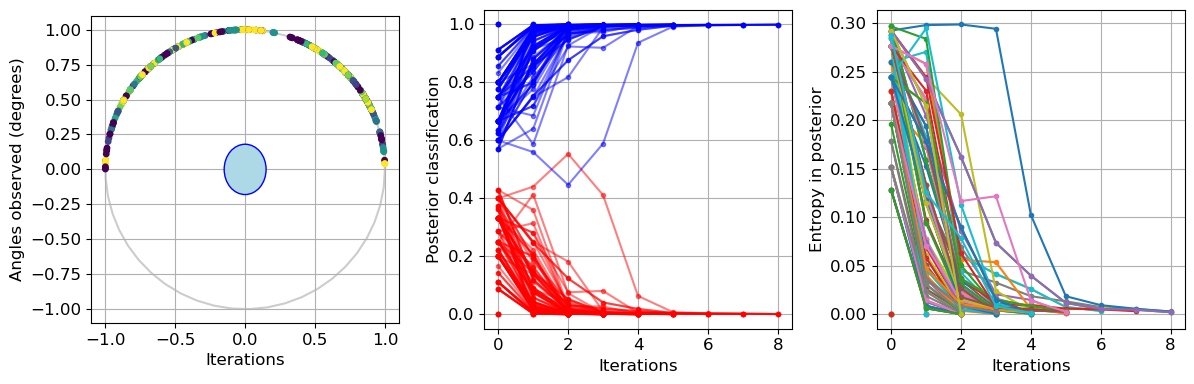

In [64]:
fig, ax_all = plt.subplots(1, 3, figsize=(4*3, 4))
plt.rcParams.update({'font.size':12})

ax = ax_all[0]
states_in_radians = np.deg2rad(states_tracked_per_trial[:,:].T)
all_angles = np.linspace(0, 2*np.pi)
x = np.cos(states_in_radians)
y = np.sin(states_in_radians)
num_steps = x.shape[0]
step_indices = np.arange(num_steps)

for trial in range(x.shape[1]):
    norm = colors.Normalize(vmin=0, vmax=time_to_complete_per_trial[trial])
    cmap = cm.viridis
    color_vals = cmap(norm(step_indices))
    ax.scatter(x[:, trial], y[:, trial], color=color_vals, s=15, zorder=2)

ax.plot(np.cos(all_angles), np.sin(all_angles), color='k', alpha=0.2, zorder=1)

# Define ellipse parameters
width = 2*a  # width
height = true_target_L  # height
ellipse_angle = 0
# Create the ellipse patch
ellipse = patches.Ellipse(
    (0, 0), width, height, angle=ellipse_angle, 
    facecolor='lightblue', edgecolor='blue', zorder=2)
ax.add_patch(ellipse)

ax.set_ylabel('Angles observed (degrees)')
ax.set_xlabel('Iterations')
ax.grid(which='both')
ax.set_aspect('equal')

ax = ax_all[1]
target_color_dict = {0:'red', 1:'blue'}
for target_num in range(target_ARs.shape[0]):
    ax.plot(current_belief_posteriors_per_trial[:,:,target_num].T, marker='.', color=target_color_dict[target_num], alpha=0.5)
ax.set_ylabel('Posterior classification')
ax.set_xlabel('Iterations')
ax.grid(which='both')

ax = ax_all[2]
ax.plot(current_belief_entropies_per_trial[:,:].T, marker='.')
ax.set_ylabel('Entropy in posterior')
ax.set_xlabel('Iterations')
ax.grid(which='both')

fig.tight_layout()

In [65]:
avg_forecasted_delta_S_per_step = np.full((num_trials, candidate_angle_steps.shape[0]), np.nan)
for trial_t in range(num_trials):
    if not(np.isnan(forecasted_delta_S_vals_per_trial[trial_t, :int(time_to_complete_per_trial[trial_t])]).all()):
        avg_forecasted_delta_S_per_step[trial_t, :] = np.nanmean(forecasted_delta_S_vals_per_trial[trial_t, :int(time_to_complete_per_trial[trial_t])], axis=0)

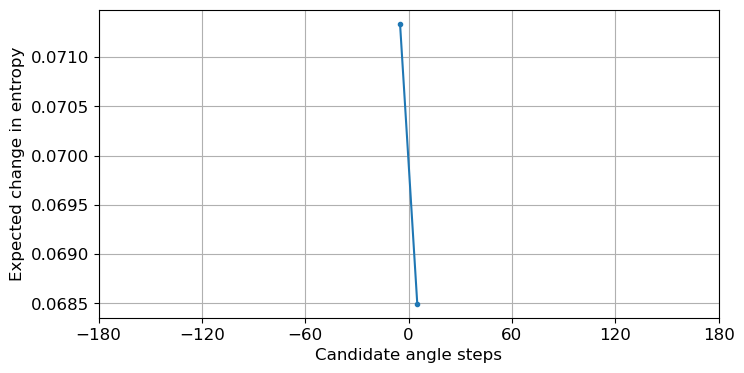

In [66]:
fig, ax = plt.subplots(1, 1, figsize=(8, 4))
ax.plot(candidate_angle_steps, np.nanmean(avg_forecasted_delta_S_per_step, axis=0), marker='.')
ax.set_ylabel('Expected change in entropy')
ax.set_xticks(np.arange(-180, 181, 60))
ax.set_xlabel('Candidate angle steps')
ax.grid(which='both')
plt.show()

In [67]:
candidate_angle_steps[angle_step_frequency_per_trial.sum(axis=0)>0]

array([-5,  5])

In [68]:
time_to_complete_per_trial

array([2., 3., 3., 5., 2., 3., 2., 8., 7., 0., 3., 3., 4., 0., 3., 2., 2.,
       5., 2., 4., 2., 4., 5., 2., 2., 4., 4., 2., 6., 6., 8., 2., 8., 2.,
       5., 2., 3., 3., 4., 4., 2., 5., 4., 3., 5., 4., 3., 2., 2., 3., 4.,
       3., 3., 3., 1., 2., 2., 0., 1., 3., 2., 3., 4., 7., 1., 3., 3., 2.,
       3., 1., 3., 0., 2., 2., 3., 3., 2., 2., 0., 3., 3., 5., 5., 0., 2.,
       2., 4., 2., 4., 4., 4., 4., 2., 5., 8., 5., 5., 3., 2., 4.])

In [69]:
f'Avg time to complete trial: {time_to_complete_per_trial[~np.isnan(time_to_complete_per_trial)].mean()} iterations'

'Avg time to complete trial: 3.18 iterations'

In [70]:
current_belief_posteriors_per_trial = np.full((num_trials, max_iter, target_ARs.shape[0]), np.nan)
current_belief_entropies_per_trial = np.full((num_trials, max_iter), np.nan)
states_tracked_per_trial = np.zeros((num_trials, max_iter))
time_to_complete_per_trial = np.full(num_trials, np.nan)
angle_step_frequency_per_trial = np.zeros((num_trials, candidate_angle_steps.shape[0]))
forecasted_delta_S_vals_per_trial = np.full((num_trials, max_iter, candidate_angle_steps.shape[0]), np.nan)
forecasted_expected_entropy_per_trial = np.full((num_trials, max_iter, candidate_angle_steps.shape[0]), np.nan)
angle_steps_taken_per_trial = np.full((num_trials, max_iter), np.nan)

for trial_t in range(num_trials):
    iter_num = 0
    alpha_targets_for_received_code = np.zeros((max_iter+1, state_centers.shape[0], target_ARs.shape[0]))

    initial_state = initial_states[trial_t]
    initial_state_prob = state_angle_step / 360

    current_belief_entropies = np.full(max_iter, np.nan)
    current_belief_posteriors = np.full((max_iter, target_ARs.shape[0]), np.nan)

    current_state = initial_state
    states_tracked = np.full(max_iter, np.nan)
    posterior = np.zeros(target_ARs.shape[0])

    while (iter_num < max_iter):
        print(f'Currently in state containing: {current_state} at t={iter_num}')
        states_tracked[iter_num] = current_state

        phi = np.deg2rad(current_state)
        fbs = dwba_prolate_spheroid(true_target_L, a, g, h, ka, phi)

        received_TS = 20*np.log10(np.abs(fbs))
        received_code = kmean_TS_codebook.predict(received_TS.reshape((1, freq.shape[0])))[0]
        print(f'Received observation and mapped to cluster {received_code}')

        A_step = state_transition_model(angle_step_to_make)

        if iter_num==0:
            alpha_targets = initial_state_prob * emission_matrix_B_targets
            alpha_targets_for_received_code[iter_num+1,:,:] = alpha_targets[:,received_code,:]
        else:
            likelihood_observing_and_transitioning = np.matmul(alpha_targets_for_received_code[iter_num,:,:].T, A_step).T
            alpha_targets_for_received_codes = likelihood_observing_and_transitioning[:, np.newaxis, :] * emission_matrix_B_targets
            alpha_targets_for_received_code[iter_num+1,:,:] = alpha_targets_for_received_codes[:,received_code,:]
            
        likelihood_targets_for_received_code = alpha_targets_for_received_code[iter_num+1,:,:].sum(axis=0)
        posterior = (likelihood_targets_for_received_code) / np.sum(likelihood_targets_for_received_code)
        current_belief_posteriors[iter_num, :] = posterior
        print(f'Posterior of current state after making observation={received_code}: {posterior}')
        entropy_of_current_belief = -1 * np.sum(posterior * np.log10(posterior + np.nextafter(0, 1)))
        current_belief_entropies[iter_num] = entropy_of_current_belief
        print(f'Entropy of current state after making observation={received_code}: {entropy_of_current_belief:.2f}')

        if (np.isclose(posterior, classification_threshold, atol=1e-3).any()):
            break
        else:
            random_index = np.random.choice(np.arange(candidate_angle_steps.shape[0]))
            angle_step_to_make = candidate_angle_steps[random_index]
            print(f'Optimal angle step to take: {angle_step_to_make} degrees clockwise')
            
            angle_step_frequency_per_trial[trial_t, random_index] += 1

            current_state = (current_state + angle_step_to_make) % 360
            print(f'Moving to: {current_state}')
            iter_num += 1

    states_tracked = np.array(states_tracked)
    states_tracked_per_trial[trial_t,:] = states_tracked
    current_belief_posteriors_per_trial[trial_t,:,:] = current_belief_posteriors
    current_belief_entropies_per_trial[trial_t,:] = current_belief_entropies
    time_to_complete_per_trial[trial_t] = iter_num

    states_tracked = np.array(states_tracked)
    states_tracked_per_trial[trial_t,:] = states_tracked
    current_belief_posteriors_per_trial[trial_t,:,:] = current_belief_posteriors
    current_belief_entropies_per_trial[trial_t,:] = current_belief_entropies
    time_to_complete_per_trial[trial_t] = iter_num

Currently in state containing: 116.52032570412887 at t=0
Received observation and mapped to cluster 68
Posterior of current state after making observation=68: [0.2 0.8]
Entropy of current state after making observation=68: 0.22
Optimal angle step to take: -5 degrees clockwise
Moving to: 111.52032570412887
Currently in state containing: 111.52032570412887 at t=1
Received observation and mapped to cluster 34
Posterior of current state after making observation=34: [0.02502803 0.97497197]
Entropy of current state after making observation=34: 0.05
Optimal angle step to take: -5 degrees clockwise
Moving to: 106.52032570412887
Currently in state containing: 106.52032570412887 at t=2
Received observation and mapped to cluster 18
Posterior of current state after making observation=18: [7.26768548e-04 9.99273231e-01]
Entropy of current state after making observation=18: 0.00
Currently in state containing: 130.91797133832117 at t=0
Received observation and mapped to cluster 40
Posterior of curren

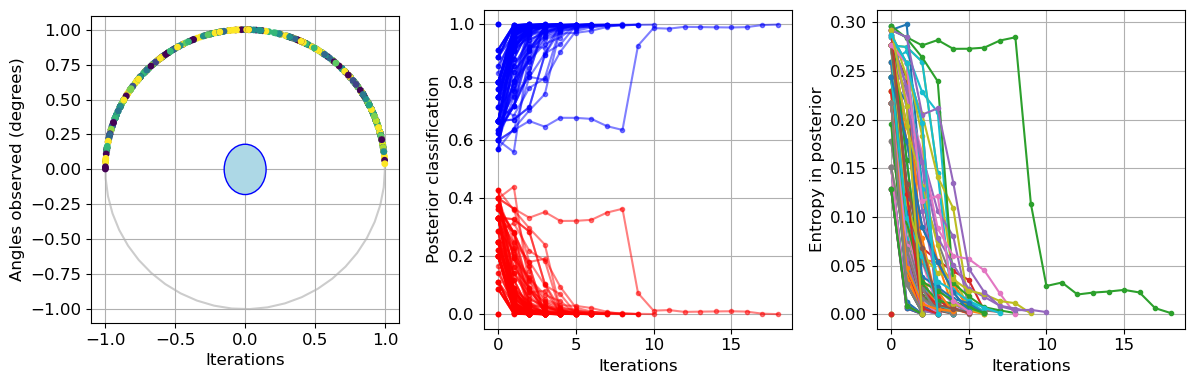

In [71]:
fig, ax_all = plt.subplots(1, 3, figsize=(4*3, 4))
plt.rcParams.update({'font.size':12})

ax = ax_all[0]
states_in_radians = np.deg2rad(states_tracked_per_trial[:,:].T)
all_angles = np.linspace(0, 2*np.pi)
x = np.cos(states_in_radians)
y = np.sin(states_in_radians)
num_steps = x.shape[0]
step_indices = np.arange(num_steps)

for trial in range(x.shape[1]):
    norm = colors.Normalize(vmin=0, vmax=time_to_complete_per_trial[trial])
    cmap = cm.viridis
    color_vals = cmap(norm(step_indices))
    ax.scatter(x[:, trial], y[:, trial], color=color_vals, s=15, zorder=2)

ax.plot(np.cos(all_angles), np.sin(all_angles), color='k', alpha=0.2, zorder=1)

# Define ellipse parameters
width = 2*a  # width
height = true_target_L  # height
ellipse_angle = 0
# Create the ellipse patch
ellipse = patches.Ellipse(
    (0, 0), width, height, angle=ellipse_angle, 
    facecolor='lightblue', edgecolor='blue', zorder=2)
ax.add_patch(ellipse)

ax.set_ylabel('Angles observed (degrees)')
ax.set_xlabel('Iterations')
ax.grid(which='both')
ax.set_aspect('equal')

ax = ax_all[1]
target_color_dict = {0:'red', 1:'blue'}
for target_num in range(target_ARs.shape[0]):
    ax.plot(current_belief_posteriors_per_trial[:,:,target_num].T, marker='.', color=target_color_dict[target_num], alpha=0.5)
ax.set_ylabel('Posterior classification')
ax.set_xlabel('Iterations')
ax.grid(which='both')

ax = ax_all[2]
ax.plot(current_belief_entropies_per_trial[:,:].T, marker='.')
ax.set_ylabel('Entropy in posterior')
ax.set_xlabel('Iterations')
ax.grid(which='both')

fig.tight_layout()

In [72]:
angle_step_frequency_per_trial.sum(axis=0)

array([206., 185.])

In [73]:
time_to_complete_per_trial

array([ 2.,  3.,  6.,  7.,  2.,  3.,  2.,  3.,  3.,  0.,  4.,  4.,  4.,
        0.,  3.,  2.,  2.,  7.,  3.,  6.,  3.,  6.,  4.,  2.,  2.,  3.,
        4.,  2.,  6.,  4.,  4.,  2., 18.,  2.,  6.,  5.,  4.,  5.,  6.,
        4.,  2.,  5.,  8.,  4.,  3.,  5.,  3.,  2.,  3.,  3.,  4.,  3.,
        4.,  4.,  5.,  4.,  8.,  0.,  3.,  3.,  2.,  6.,  6.,  5.,  3.,
        4.,  3.,  3.,  6.,  7.,  6.,  0.,  2.,  3.,  3.,  4.,  2.,  2.,
        0.,  4.,  3.,  4.,  6.,  0.,  9.,  2.,  3.,  4.,  9.,  5.,  5.,
        4.,  2.,  3., 10.,  5.,  5.,  2.,  2.,  3.])

In [74]:
f'Avg time to complete trial: {time_to_complete_per_trial[~np.isnan(time_to_complete_per_trial)].mean()} iterations'

'Avg time to complete trial: 3.91 iterations'

In [75]:
current_belief_posteriors_per_trial = np.full((num_trials, max_iter, target_ARs.shape[0]), np.nan)
current_belief_entropies_per_trial = np.full((num_trials, max_iter), np.nan)
states_tracked_per_trial = np.zeros((num_trials, max_iter))
time_to_complete_per_trial = np.full(num_trials, np.nan)
angle_step_frequency_per_trial = np.zeros((num_trials, candidate_angle_steps.shape[0]))
forecasted_delta_S_vals_per_trial = np.full((num_trials, max_iter, candidate_angle_steps.shape[0]), np.nan)
forecasted_expected_entropy_per_trial = np.full((num_trials, max_iter, candidate_angle_steps.shape[0]), np.nan)
angle_steps_taken_per_trial = np.full((num_trials, max_iter), np.nan)

for trial_t in range(num_trials):
    iter_num = 0
    alpha_targets_for_received_code = np.zeros((max_iter+1, state_centers.shape[0], target_ARs.shape[0]))

    initial_state = initial_states[trial_t]
    initial_state_prob = state_angle_step / 360

    current_belief_entropies = np.full(max_iter, np.nan)
    current_belief_posteriors = np.full((max_iter, target_ARs.shape[0]), np.nan)

    current_state = initial_state
    states_tracked = np.full(max_iter, np.nan)
    posterior = np.zeros(target_ARs.shape[0])

    while (iter_num < max_iter):
        print(f'Currently in state containing: {current_state} at t={iter_num}')
        states_tracked[iter_num] = current_state

        phi = np.deg2rad(current_state)
        fbs = dwba_prolate_spheroid(true_target_L, a, g, h, ka, phi)

        received_TS = 20*np.log10(np.abs(fbs))
        received_code = kmean_TS_codebook.predict(received_TS.reshape((1, freq.shape[0])))[0]
        print(f'Received observation and mapped to cluster {received_code}')

        A_step = state_transition_model(angle_step_to_make)

        if iter_num==0:
            alpha_targets = initial_state_prob * emission_matrix_B_targets
            alpha_targets_for_received_code[iter_num+1,:,:] = alpha_targets[:,received_code,:]
        else:
            likelihood_observing_and_transitioning = np.matmul(alpha_targets_for_received_code[iter_num,:,:].T, A_step).T
            alpha_targets_for_received_codes = likelihood_observing_and_transitioning[:, np.newaxis, :] * emission_matrix_B_targets
            alpha_targets_for_received_code[iter_num+1,:,:] = alpha_targets_for_received_codes[:,received_code,:]
            
        likelihood_targets_for_received_code = alpha_targets_for_received_code[iter_num+1,:,:].sum(axis=0)
        posterior = (likelihood_targets_for_received_code) / np.sum(likelihood_targets_for_received_code)
        current_belief_posteriors[iter_num, :] = posterior
        print(f'Posterior of current state after making observation={received_code}: {posterior}')
        entropy_of_current_belief = -1 * np.sum(posterior * np.log10(posterior + np.nextafter(0, 1)))
        current_belief_entropies[iter_num] = entropy_of_current_belief
        print(f'Entropy of current state after making observation={received_code}: {entropy_of_current_belief:.2f}')

        if (np.isclose(posterior, classification_threshold, atol=1e-3).any()):
            break
        else:
            angle_step_to_make = 0
            print(f'Optimal angle step to take: {angle_step_to_make} degrees clockwise')
            
            print(f'Moving to: {current_state}')
            iter_num += 1

    states_tracked = np.array(states_tracked)
    states_tracked_per_trial[trial_t,:] = states_tracked
    current_belief_posteriors_per_trial[trial_t,:,:] = current_belief_posteriors
    current_belief_entropies_per_trial[trial_t,:] = current_belief_entropies
    time_to_complete_per_trial[trial_t] = iter_num

Currently in state containing: 116.52032570412887 at t=0
Received observation and mapped to cluster 68
Posterior of current state after making observation=68: [0.2 0.8]
Entropy of current state after making observation=68: 0.22
Optimal angle step to take: 0 degrees clockwise
Moving to: 116.52032570412887
Currently in state containing: 116.52032570412887 at t=1
Received observation and mapped to cluster 68
Posterior of current state after making observation=68: [0.05882353 0.94117647]
Entropy of current state after making observation=68: 0.10
Optimal angle step to take: 0 degrees clockwise
Moving to: 116.52032570412887
Currently in state containing: 116.52032570412887 at t=2
Received observation and mapped to cluster 68
Posterior of current state after making observation=68: [0.01538462 0.98461538]
Entropy of current state after making observation=68: 0.03
Optimal angle step to take: 0 degrees clockwise
Moving to: 116.52032570412887
Currently in state containing: 116.52032570412887 at t

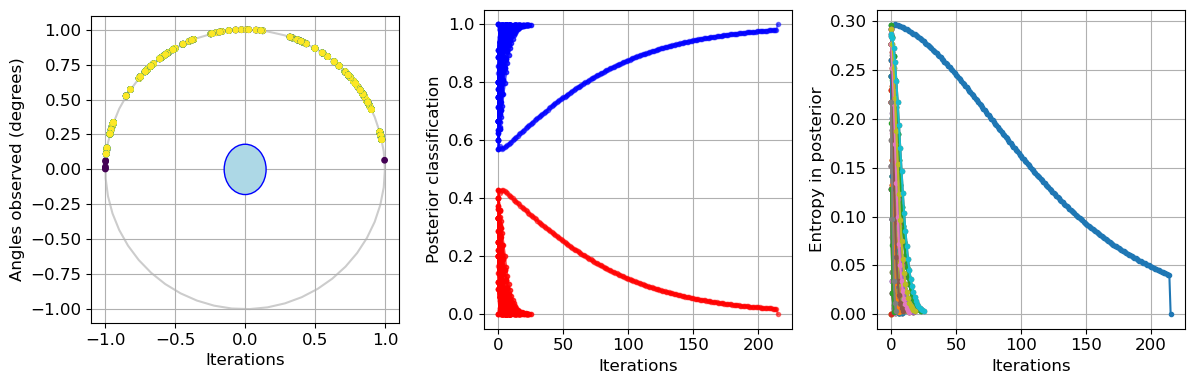

In [76]:
fig, ax_all = plt.subplots(1, 3, figsize=(4*3, 4))
plt.rcParams.update({'font.size':12})

ax = ax_all[0]
states_in_radians = np.deg2rad(states_tracked_per_trial[:,:].T)
all_angles = np.linspace(0, 2*np.pi)
x = np.cos(states_in_radians)
y = np.sin(states_in_radians)
num_steps = x.shape[0]
step_indices = np.arange(num_steps)

for trial in range(x.shape[1]):
    norm = colors.Normalize(vmin=0, vmax=time_to_complete_per_trial[trial])
    cmap = cm.viridis
    color_vals = cmap(norm(step_indices))
    ax.scatter(x[:, trial], y[:, trial], color=color_vals, s=15, zorder=2)

ax.plot(np.cos(all_angles), np.sin(all_angles), color='k', alpha=0.2, zorder=1)

# Define ellipse parameters
width = 2*a  # width
height = true_target_L  # height
ellipse_angle = 0
# Create the ellipse patch
ellipse = patches.Ellipse(
    (0, 0), width, height, angle=ellipse_angle, 
    facecolor='lightblue', edgecolor='blue', zorder=2)
ax.add_patch(ellipse)

ax.set_ylabel('Angles observed (degrees)')
ax.set_xlabel('Iterations')
ax.grid(which='both')
ax.set_aspect('equal')

ax = ax_all[1]
target_color_dict = {0:'red', 1:'blue'}
for target_num in range(target_ARs.shape[0]):
    ax.plot(current_belief_posteriors_per_trial[:,:,target_num].T, marker='.', color=target_color_dict[target_num], alpha=0.5)
ax.set_ylabel('Posterior classification')
ax.set_xlabel('Iterations')
ax.grid(which='both')

ax = ax_all[2]
ax.plot(current_belief_entropies_per_trial[:,:].T, marker='.')
ax.set_ylabel('Entropy in posterior')
ax.set_xlabel('Iterations')
ax.grid(which='both')

fig.tight_layout()

In [77]:
angle_step_frequency_per_trial.sum(axis=0)

array([0., 0.])

In [78]:
f'Avg time to complete trial: {time_to_complete_per_trial[~np.isnan(time_to_complete_per_trial)].mean()} iterations'

'Avg time to complete trial: 10.16 iterations'

In [79]:
time_to_complete_per_trial

array([  4.,   6.,  10.,   9.,   3.,   6.,   3.,   8.,   7.,   0.,   9.,
         7.,   9.,   0.,   8.,   4.,   2.,   7.,   4.,  10.,   4.,   9.,
         6.,   4.,   4.,  25.,  23.,   3.,  14.,  14., 215.,   8.,  17.,
         2.,   7.,  14.,   6.,   6.,  17.,  23.,   3.,  14.,  23.,  10.,
        17.,   6.,   9.,   7.,   3.,   4.,   6.,   7.,   9.,   6.,   8.,
         4.,  14.,   0.,   8.,   6.,   2.,   9.,  23.,  10.,   8.,   4.,
         9.,   4.,  10.,   8.,   8.,   0.,   4.,   7.,   4.,   9.,   3.,
         4.,   0.,   9.,   6.,   6.,   6.,   0.,  18.,   2.,   6.,   3.,
         9.,   6.,   6.,   6.,   2.,  17.,  17.,   9.,  14.,   4.,  18.,
        25.])